<a href="https://colab.research.google.com/github/amangupta2/ai_weather/blob/main/Comparing_WeatherBench_with_Meteostat_radars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note that pip might complain about some versions but the notebook should still work as expected.
!pip install git+https://github.com/google-research/weatherbenchX.git
#!pip install stationbench
!pip install cartopy
! pip install netCDF4
! pip install meteostat

  Cloning https://github.com/google-research/weatherbenchX.git to /tmp/pip-req-build-6nul2f0b
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/weatherbenchX.git /tmp/pip-req-build-6nul2f0b
  Resolved https://github.com/google-research/weatherbenchX.git to commit 0fa584bfcdbcb2c33002b23410bb920b97d8ca88
  Preparing metadata (setup.py) ... done


In [2]:
import apache_beam as beam
import numpy as np
import xarray as xr
import weatherbenchX
from weatherbenchX.data_loaders import xarray_loaders
from weatherbenchX.metrics import deterministic
from weatherbenchX.metrics import base as metrics_base
from weatherbenchX import aggregation
from weatherbenchX import weighting
from weatherbenchX import binning
from weatherbenchX import time_chunks
from weatherbenchX import beam_pipeline
#import stationbench

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#
from netCDF4 import Dataset

#import numpy as np
from datetime import datetime, timedelta
#import matplotlib.pyplot as plt
from meteostat import Point, Daily, Monthly, Hourly, Stations
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

In [3]:
from google.colab import auth, drive

# Authenticate user
#auth.authenticate_user()
# connect Google Drive
drive.mount('/content/drive')
# load file
f = '/content/drive/MyDrive/ERA5_lsm.nc'
nc = Dataset(f)
lsm = nc.variables['lsm'][0,:,:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Defining error metric functions

# Compute latitude weighted RMSE wrt ERA5: globally and over India
def RMSE(pred, truth, lat):

  anom = pred - truth
  factor = np.cos(np.pi*lat/180.)
  factor2 = np.cos(np.pi*lat[208:329]/180.)

  rmse_global = np.sqrt(np.mean(np.mean(anom**2,2),1)) #np.sqrt(np.mean(np.mean(anom**2,2)*factor[np.newaxis,:],1)/np.mean(factor))
  rmse_india  = np.sqrt(np.mean(np.mean(anom[:,208:329,272:393]**2,2),1)) #np.sqrt(np.mean(np.mean(anom[:,208:329,272:393]**2,2)*factor2[np.newaxis,:],1)/np.mean(factor2))

  return rmse_global, rmse_india

# Compute latitude-weighted MAE: globally and over India
def MAE(pred, truth, lat):

  anom = pred - truth
  factor = np.cos(np.pi*lat/180.)
  factor2 = np.cos(np.pi*lat[208:329]/180.)

  mae_global = np.mean(np.mean(np.abs(anom),2),1)
  mae_india  = np.mean(np.mean(np.abs(anom)[:,208:329,272:393],2),1)

  return mae_global, mae_india


# Compute latitude-weighted anomaly correlation coefficient: globally and over India
def ACC(pred, truth, lat):
  ...

# Full-year analysis

In [6]:
# ======================== WEATHERBENCH =================================
# Ground truth to compare to
target_path_era5_analysis     = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'
target_path_hres_analysis     = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'

# ============ AI + TRADITIONAL FORECASTS ====================
prediction_path_pangu         = 'gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
prediction_path_graphcast     = 'gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
prediction_path_fuxi          = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'

prediction_path_panguoper     = 'gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
prediction_path_graphcastoper = 'gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'

# traditional model forecasts
prediction_path_ifshres_forecast  = 'gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
prediction_path_ifsens_forecast   = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721_mean.zarr' # can remove "_mean" to get the full ensemble
prediction_path_era5_forecast     = 'gs://weatherbench2/datasets/era5-forecasts/2020-1440x721.zarr'


ds_era5 = xr.open_zarr(
    target_path_era5_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_hres = xr.open_zarr(
    target_path_hres_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_pangu = xr.open_zarr(
    prediction_path_pangu,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcast = xr.open_zarr(
    prediction_path_graphcast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_fuxi = xr.open_zarr(
    prediction_path_fuxi,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_panguoper = xr.open_zarr(
    prediction_path_panguoper,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcastoper = xr.open_zarr(
    prediction_path_graphcastoper,
    chunks=None,
    storage_options=dict(token='anon'),
)


# traditional
ds_ifshres_fcst = xr.open_zarr(
    prediction_path_ifshres_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_ifsens_fcst = xr.open_zarr(
    prediction_path_ifsens_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_era5_fcst = xr.open_zarr(
    prediction_path_era5_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)

# =================== RADAR =========================
# might need to  loop over all radars later
# for now, just 3 with continuous timeseries and no NaNs
delhi       = Point(28.6439835,76.9280785)
madras      = Point(13.0, 80.1833)
agartala    = Point(23.8315, 91.2868)
calcutta    = Point(22.5333, 88.3333)

# ============= averaging locations
# delhi
lat0=28.6439835
lon0=76.9280785

#madras
#lat0=13.
#lon0=80.1833

# calcutta
#lat0=22.5333
#lon0=88.3333





# define interpolator function - this could be more accurate | simple average right now
def interp(a,b,c,d):
  return (a+b+c+d)/4.

def linearinterp2d(a,b,c,d,x1,x2,y1,y2):
  return (a+b+c+d)/4.

In [ ]:
temp_radar_avg         = 0.
temp_era5_avg          = 0.
temp_hres_avg          = 0.
temp_hres_fcst_avg     = 0.
temp_hresens_fcst_avg  = 0.
temp_pangu_avg         = 0.
temp_panguoper_avg     = 0.
temp_fuxi_avg          = 0.
temp_graphcast_avg     = 0.
temp_graphcastoper_avg = 0.
temp_era5_fcst_avg     = 0.

# ========= MAE ============
# === Traditional ========
mae_era5_radar = 0.
mae_hres_radar = 0.
mae_era5fcst_radar = 0.
mae_hresfcst_radar = 0.
mae_hresensfcst_radar = 0.

# ====== AI NWP ==========
mae_pangu_era5  = 0.
mae_pangu_hres  = 0.
mae_pangu_radar = 0.

mae_panguoper_era5  = 0.
mae_panguoper_hres  = 0.
mae_panguoper_radar = 0.

mae_graphcast_era5  = 0.
mae_graphcast_hres  = 0.
mae_graphcast_radar = 0.

mae_graphcastoper_era5  = 0.
mae_graphcastoper_hres  = 0.
mae_graphcastoper_radar = 0.

mae_fuxi_era5  = 0.
mae_fuxi_hres  = 0.
mae_fuxi_radar = 0.




# ========= RMAE ===========
# === Traditional ========
rmae_era5_radar = 0.
rmae_hres_radar = 0.
rmae_era5fcst_radar = 0.
rmae_hresfcst_radar = 0.
rmae_hresensfcst_radar = 0.

# ====== AI NWP ==========
rmae_pangu_era5  = 0.
rmae_pangu_hres  = 0.
rmae_pangu_radar = 0.

rmae_panguoper_era5  = 0.
rmae_panguoper_hres  = 0.
rmae_panguoper_radar = 0.

rmae_graphcast_era5  = 0.
rmae_graphcast_hres  = 0.
rmae_graphcast_radar = 0.

rmae_graphcastoper_era5  = 0.
rmae_graphcastoper_hres  = 0.
rmae_graphcastoper_radar = 0.

rmae_fuxi_era5  = 0.
rmae_fuxi_hres  = 0.
rmae_fuxi_radar = 0.


initdate = datetime(2020,1,1,0,0,0)
p1=0
p2=8 # 20 | 8 for 48 hours

v = np.arange(0,12*702,48) # FuXi is only till 16 December. Ugh. Use 700 instead of 732
#v = np.arange(0,732,48)
N = len(v)
#v = np.arange(0,12,12)
for i in v:
  print(i)
  date = initdate + timedelta(hours=int(i))

  # for radar
  start = date
  end   = date + timedelta(hours=48)

  # get radar timeseries for next 48 hours | generalise to all radars later
  radar_data       = Hourly(delhi,start,end) # daily
  #radar_data      = Hourly(madras,start,end)
  #radar_data    = Hourly(calcutta,start,end)

  # only for temperature right now - 6 hourly | generalise to all radars later
  temp_radar       = (radar_data.fetch()['temp'][0::6]).values + 273.16
  #madras_temp      = madras_data.fetch()['temp'][0::6]
  #agartala_temp    = agartala_data.fetch()['temp'][0::6]
  #calcutta_temp    = calcutta_data.fetch()['temp'][0::6]
  # load wind speed
  # load wind orientation

  #print(temp_radar)

  # for weatherbench
  time1=f'{start.year}-{str(start.month).zfill(2)}-{str(start.day).zfill(2)}T{str(start.hour).zfill(2)}:00:00.000000000'
  time2=f'{end.year}-{str(end.month).zfill(2)}-{str(end.day).zfill(2)}T{str(end.hour).zfill(2)}:00:00.000000000'

  data_era5          = ds_era5.sel(time=slice(time1, time2))
  data_hres          = ds_hres.sel(time=slice(time1, time2))
  # --------------------------------------------------------------------
  data_pangu         = ds_pangu.sel(time=slice(time1, time1))
  data_graphcast     = ds_graphcast.sel(time=slice(time1, time1))
  data_fuxi          = ds_fuxi.sel(time=slice(time1, time1))
  # --------------------------------------------------------------------
  data_panguoper     = ds_panguoper.sel(time=slice(time1, time1))
  data_graphcastoper = ds_graphcastoper.sel(time=slice(time1, time1))
  # --------------------------------------------------------------------
  data_ifshres_fcst  = ds_ifshres_fcst.sel(time=slice(time1, time1))
  data_ifsens_fcst   = ds_ifsens_fcst.sel(time=slice(time1, time1))
  data_era5_fcst     = ds_era5_fcst.sel(time=slice(time1, time1))


  if i == 0:
    lat1 = data_era5['latitude'].values
    lat2 = data_hres['latitude'].values
    lon = data_era5['longitude'].values
    ix1=len(lon[lon<lon0])-1
    ix2=len(lon[lon<lon0])

    # ERA5, Pangu, and PanguOpen will use this
    iy1_desc=len(lat1[lat1>lat0])-1
    iy2_desc=len(lat1[lat1>lat0])

    # Rest will use this
    iy1_asc=len(lat2[lat2<lat0])-1
    iy2_asc=len(lat2[lat2<lat0])

  #p_era5 = data_era5['level'].values
  t_era5 = data_era5['2m_temperature'].values
  #u_era5 = data_era5['10m_u_component_of_wind']
  #v_era5 = data_era5['10m_v_component_of_wind']

  #p_hres = data_hres['level'].values
  t_hres = data_hres['2m_temperature'].values
  #u_hres = data_hres['10m_u_component_of_wind'].values
  #v_hres = data_hres['10m_v_component_of_wind'].values

  #p_pangu = data_pangu['level'].values
  t_pangu = data_pangu['2m_temperature'][0,p1:p2,:,:].values
  #u_pangu = data_pangu['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_pangu = data_pangu['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_graphcast = data_graphcast['level'].values
  t_graphcast = data_graphcast['2m_temperature'][0,p1:p2,:,:].values
  #u_graphcast = data_graphcast['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_graphcast = data_graphcast['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_fuxi = data_fuxi['level'].values
  t_fuxi = data_fuxi['2m_temperature'][0,p1:p2,:,:].values
  #u_fuxi = data_fuxi['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_fuxi = data_fuxi['10m_v_component_of_wind'][0,p1:p2,:,:].values

  #p_panguoper = data_panguoper['level'].values
  t_panguoper = data_panguoper['2m_temperature'][0,p1:p2,:,:].values
  #u_panguoper = data_panguoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_panguoper = data_panguoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
  #u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_ifshres_fcst  = data_ifshres_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
  #u_ifshres_fcst  = data_ifshres_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_ifshres_fcst  = data_ifshres_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_ifsens_fcst   = data_ifsens_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
  #u_ifsens_fcst   = data_ifsens_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
  #v_ifsens_fcst   = data_ifsens_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

  t_era5_fcst     = data_era5_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values # since it starts from 0
  #u_era5_fcst     = data_era5_fcst['10m_u_component_of_wind'][0,p1+1:p2+1,:,:].values
  #v_era5_fcst     = data_era5_fcst['10m_v_component_of_wind'][0,p1+1:p2+1,:,:].values

  # improve the interp function for accuracy gains
  print(f'{t_era5[:,iy1_desc,ix1].shape}')
  temp_era5          = interp(t_era5[:,iy1_desc,ix1], t_era5[:,iy1_desc,ix2], t_era5[:,iy2_desc,ix1], t_era5[:,iy2_desc,ix2] )
  temp_hres          = interp(t_hres[:,iy1_asc,ix1], t_hres[:,iy1_asc,ix2], t_hres[:,iy2_asc,ix1], t_hres[:,iy2_asc,ix2])
  temp_hres_fcst     = interp(t_ifshres_fcst[:,iy1_asc,ix1], t_ifshres_fcst[:,iy1_asc,ix2], t_ifshres_fcst[:,iy2_asc,ix1], t_ifshres_fcst[:,iy2_asc,ix2])
  temp_hresens_fcst  = interp(t_ifsens_fcst[:,iy1_asc,ix1], t_ifsens_fcst[:,iy1_asc,ix2], t_ifsens_fcst[:,iy2_asc,ix1], t_ifsens_fcst[:,iy2_asc,ix2])
  temp_pangu         = interp(t_pangu[:,iy1_desc,ix1], t_pangu[:,iy1_desc,ix2], t_pangu[:,iy2_desc,ix1], t_pangu[:,iy2_desc,ix2])
  temp_panguoper     = interp(t_panguoper[:,iy1_desc,ix1], t_panguoper[:,iy1_desc,ix2], t_panguoper[:,iy2_desc,ix1], t_panguoper[:,iy2_desc,ix2])
  temp_fuxi          = interp(t_fuxi[:,iy1_asc,ix1], t_fuxi[:,iy1_asc,ix2], t_fuxi[:,iy2_asc,ix1], t_fuxi[:,iy2_asc,ix2])
  temp_graphcast     = interp(t_graphcast[:,iy1_asc,ix1], t_graphcast[:,iy1_asc,ix2], t_graphcast[:,iy2_asc,ix1], t_graphcast[:,iy2_asc,ix2])
  temp_graphcastoper = interp(t_graphcastoper[:,iy1_asc,ix1], t_graphcastoper[:,iy1_asc,ix2], t_graphcastoper[:,iy2_asc,ix1], t_graphcastoper[:,iy2_asc,ix2])
  temp_era5_fcst     = interp(t_era5_fcst[:,iy1_asc,ix1], t_era5_fcst[:,iy1_asc,ix2], t_era5_fcst[:,iy2_asc,ix1], t_era5_fcst[:,iy2_asc,ix2])

  #print(f'{temp_radar.shape=}')
  #print(f'{temp_hres.shape=}')
  #print(f'{temp_pangu.shape=}')
  #print(f'{temp_era5_fcst.shape=}')

  # All data loaded and interpolated
  temp_radar_avg         += temp_radar/N
  temp_era5_avg          += temp_era5/N
  temp_hres_avg          += temp_hres/N
  temp_hres_fcst_avg     += temp_hres_fcst/N
  temp_hresens_fcst_avg  += temp_hresens_fcst/N
  temp_pangu_avg         += temp_pangu/N
  temp_panguoper_avg     += temp_panguoper/N
  temp_fuxi_avg          += temp_fuxi/N
  temp_graphcast_avg     += temp_graphcast/N
  temp_graphcastoper_avg += temp_graphcastoper/N
  temp_era5_fcst_avg     += temp_era5_fcst/N


  # ================== MAE ========================================================
  # groud truth
  mae_era5_radar += np.abs(temp_era5 - temp_radar)/N
  mae_hres_radar += np.abs(temp_hres - temp_radar)/N

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  mae_era5fcst_radar    += np.abs(temp_era5_fcst - temp_radar[1:])/N
  mae_hresfcst_radar    += np.abs(temp_hres_fcst - temp_radar[1:])/N
  mae_hresensfcst_radar += np.abs(temp_hresens_fcst - temp_radar[1:])/N

  mae_pangu_era5  += np.abs(temp_pangu - temp_era5[1:])/N
  mae_pangu_hres  += np.abs(temp_pangu - temp_hres[1:])/N
  mae_pangu_radar += np.abs(temp_pangu - temp_radar[1:])/N

  mae_panguoper_era5  += np.abs(temp_panguoper - temp_era5[1:])/N
  mae_panguoper_hres  += np.abs(temp_panguoper - temp_hres[1:])/N
  mae_panguoper_radar += np.abs(temp_panguoper - temp_radar[1:])/N

  mae_graphcast_era5  += np.abs(temp_graphcast - temp_era5[1:])/N
  mae_graphcast_hres  += np.abs(temp_graphcast - temp_hres[1:])/N
  mae_graphcast_radar += np.abs(temp_graphcast - temp_radar[1:])/N

  mae_graphcastoper_era5  += np.abs(temp_graphcastoper - temp_era5[1:])/N
  mae_graphcastoper_hres  += np.abs(temp_graphcastoper - temp_hres[1:])/N
  mae_graphcastoper_radar += np.abs(temp_graphcastoper - temp_radar[1:])/N

  mae_fuxi_era5  += np.abs(temp_fuxi - temp_era5[1:])/N
  mae_fuxi_hres  += np.abs(temp_fuxi - temp_hres[1:])/N
  mae_fuxi_radar += np.abs(temp_fuxi - temp_radar[1:])/N


  # ================== RMAE ========================================================
  # groud truth
  rmae_era5_radar += np.abs(temp_era5 - temp_radar)/(N*temp_radar)
  rmae_hres_radar += np.abs(temp_hres - temp_radar)/(N*temp_radar)

  # compute MAE (and prob. ACC) in prediction vs radar | ERA5 | HRES
  rmae_era5fcst_radar    += np.abs(temp_era5_fcst - temp_radar[1:])/(N*temp_radar[1:])
  rmae_hresfcst_radar    += np.abs(temp_hres_fcst - temp_radar[1:])/(N*temp_radar[1:])
  rmae_hresensfcst_radar += np.abs(temp_hresens_fcst - temp_radar[1:])/(N*temp_radar[1:])

  rmae_pangu_era5  += np.abs(temp_pangu - temp_era5[1:])/(N*temp_era5[1:])
  rmae_pangu_hres  += np.abs(temp_pangu - temp_hres[1:])/(N*temp_hres[1:])
  rmae_pangu_radar += np.abs(temp_pangu - temp_radar[1:])/(N*temp_radar[1:])

  rmae_panguoper_era5  += np.abs(temp_panguoper - temp_era5[1:])/(N*temp_era5[1:])
  rmae_panguoper_hres  += np.abs(temp_panguoper - temp_hres[1:])/(N*temp_hres[1:])
  rmae_panguoper_radar += np.abs(temp_panguoper - temp_radar[1:])/(N*temp_radar[1:])

  rmae_graphcast_era5  += np.abs(temp_graphcast - temp_era5[1:])/(N*temp_era5[1:])
  rmae_graphcast_hres  += np.abs(temp_graphcast - temp_hres[1:])/(N*temp_hres[1:])
  rmae_graphcast_radar += np.abs(temp_graphcast - temp_radar[1:])/(N*temp_radar[1:])

  rmae_graphcastoper_era5  += np.abs(temp_graphcastoper - temp_era5[1:])/(N*temp_era5[1:])
  rmae_graphcastoper_hres  += np.abs(temp_graphcastoper - temp_hres[1:])/(N*temp_hres[1:])
  rmae_graphcastoper_radar += np.abs(temp_graphcastoper - temp_radar[1:])/(N*temp_radar[1:])

  rmae_fuxi_era5  += np.abs(temp_fuxi - temp_era5[1:])/(N*temp_era5[1:])
  rmae_fuxi_hres  += np.abs(temp_fuxi - temp_hres[1:])/(N*temp_hres[1:])
  rmae_fuxi_radar += np.abs(temp_fuxi - temp_radar[1:])/(N*temp_radar[1:])


0


(9,)
48


(9,)
96


(9,)
144


(9,)
192


(9,)
240


(9,)
288


(9,)
336


(9,)
384


(9,)
432


(9,)
480


(9,)
528


(9,)
576


(9,)
624


(9,)
672


(9,)
720


(9,)
768


(9,)
816


(9,)
864


(9,)
912


(9,)
960


(9,)
1008


(9,)
1056


(9,)
1104


(9,)
1152


(9,)
1200


(9,)
1248


(9,)
1296


(9,)
1344


(9,)
1392


(9,)
1440


(9,)
1488


(9,)
1536


(9,)
1584


(9,)
1632


(9,)
1680


(9,)
1728


(9,)
1776


(9,)
1824


(9,)
1872


(9,)
1920


(9,)
1968


(9,)
2016


(9,)
2064


(9,)
2112


(9,)
2160


(9,)
2208


(9,)
2256


(9,)
2304


(9,)
2352


(9,)
2400


(9,)
2448


(9,)
2496


(9,)
2544


(9,)
2592


(9,)
2640


(9,)
2688


(9,)
2736


(9,)
2784


(9,)
2832


(9,)
2880


(9,)
2928


(9,)
2976


(9,)
3024


(9,)
3072


(9,)
3120


(9,)
3168


(9,)
3216


(9,)
3264


(9,)
3312


(9,)
3360


(9,)
3408


(9,)
3456


(9,)
3504


(9,)
3552


(9,)
3600


(9,)
3648


(9,)
3696


(9,)
3744


(9,)
3792


(9,)
3840


(9,)
3888


(9,)
3936


(9,)
3984


(9,)
4032


(9,)
4080


(9,)
4128


(9,)
4176


(9,)
4224


(9,)
4272


(9,)
4320


(9,)
4368


(9,)
4416


(9,)
4464


(9,)
4512


(9,)
4560


(9,)
4608


(9,)
4656


(9,)
4704


(9,)
4752


(9,)
4800


(9,)
4848


(9,)
4896


(9,)
4944


(9,)
4992


(9,)
5040


(9,)
5088


(9,)
5136


(9,)
5184


(9,)
5232


(9,)
5280


(9,)
5328


(9,)
5376


(9,)
5424


(9,)
5472


(9,)
5520


(9,)
5568


(9,)
5616


(9,)
5664


(9,)
5712


(9,)
5760


(9,)
5808


(9,)
5856


(9,)
5904


(9,)
5952


(9,)
6000


(9,)
6048


(9,)
6096


(9,)
6144


(9,)
6192


(9,)
6240


(9,)
6288


(9,)
6336


(9,)
6384


(9,)
6432


(9,)
6480


(9,)
6528


(9,)
6576


(9,)
6624


(9,)
6672


(9,)
6720


(9,)
6768


(9,)
6816


(9,)
6864


(9,)
6912


(9,)
6960


(9,)
7008


(9,)
7056


(9,)
7104


(9,)
7152


(9,)
7200


(9,)
7248


(9,)
7296


(9,)
7344


(9,)
7392


(9,)
7440


(9,)
7488


(9,)
7536


(9,)
7584


(9,)
7632


(9,)
7680


(9,)
7728


(9,)
7776


(9,)
7824


(9,)
7872


(9,)
7920


(9,)
7968


(9,)
8016


(9,)
8064


(9,)
8112


(9,)
8160


(9,)
8208


(9,)
8256


(9,)
8304


(9,)
8352


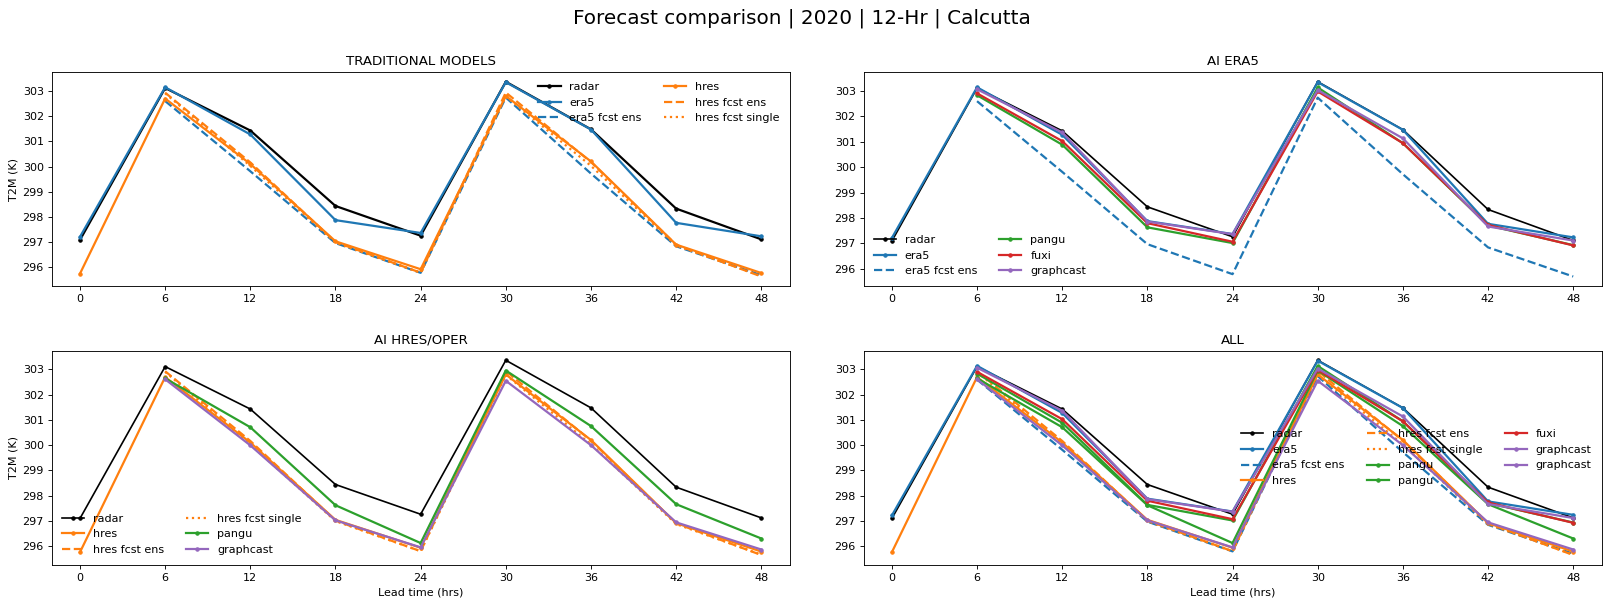

In [ ]:
# Forcast metrics computed over a

lw=2
t = np.arange(0,48+6,6)

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')

fig.suptitle('Forecast comparison | 2020 | 48-Hr | Delhi', size=18)

plt.subplot(221)

plt.plot(t,temp_radar_avg, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t, temp_era5_avg, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[1:], temp_era5_fcst_avg, '--', linewidth=lw, color='C0', label='era5 fcst ens')

plt.plot(t, temp_hres_avg, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[1:], temp_hresens_fcst_avg, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[1:], temp_hres_fcst_avg, ':', color='C1', linewidth=lw, label='hres fcst single')

plt.legend(frameon=False, ncol=2)
plt.title('TRADITIONAL MODELS')
plt.ylabel('T2M (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(222)

plt.plot(t,temp_radar_avg, '.-', color='k', label='radar')

plt.plot(t, temp_era5_avg, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[1:], temp_era5_fcst_avg, '--', color='C0', linewidth=lw, label='era5 fcst ens')

plt.plot(t[1:], temp_pangu_avg, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], temp_fuxi_avg, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], temp_graphcast_avg, '.-', color='C4', linewidth=lw, label='graphcast')


plt.legend(frameon=False, ncol=2)
plt.title('AI ERA5')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(223)

plt.plot(t,temp_radar_avg, '.-', color='k', label='radar')

plt.plot(t, temp_hres_avg, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[1:], temp_hresens_fcst_avg, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[1:], temp_hres_fcst_avg, ':', color='C1', linewidth=lw, label='hres fcst single')


plt.plot(t[1:], temp_panguoper_avg, '.-', color='C2', linewidth=lw, label='panguoper')
plt.plot(t[1:], temp_graphcastoper_avg, '.-', color='C4', linewidth=lw, label='graphcastoper')


plt.legend(frameon=False, ncol=2)
plt.title('AI HRES/OPER')
plt.xlabel('Lead time (hrs)')
plt.ylabel('T2M (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(224)

plt.plot(t,temp_radar_avg, '.-', color='k', label='radar')

plt.plot(t, temp_era5_avg, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[1:], temp_era5_fcst_avg, '--', linewidth=lw, color='C0', label='era5 fcst ens')

plt.plot(t, temp_hres_avg, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[1:], temp_hresens_fcst_avg, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[1:], temp_hres_fcst_avg, ':', color='C1', linewidth=lw, label='hres fcst single')

plt.plot(t[1:], temp_pangu_avg, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], temp_panguoper_avg, '.-', color='C2', linewidth=lw, label='panguoper')
plt.plot(t[1:], temp_fuxi_avg, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], temp_graphcast_avg, '.-', color='C4', linewidth=lw, label='graphcast')
plt.plot(t[1:], temp_graphcastoper_avg, '.-', color='C4', linewidth=lw, label='graphcastoper')

plt.xlabel('Lead time (hrs)')


plt.legend(frameon=False, ncol=3)
plt.title('ALL')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))

plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.savefig('drive/MyDrive/makdi/t2m_comparison_yearly2020_delhi.png', bbox_inches='tight')

In [ ]:
rmae_era5fcst_radar    += np.abs(temp_era5_fcst - temp_radar[1:])/(N*temp_radar[1:])
  rmae_hresfcst_radar    += np.abs(temp_hres_fcst - temp_radar[1:])/(N*temp_radar[1:])
  rmae_hresensfcst_radar += np.abs(temp_hresens_fcst - temp_radar[1:])/(N*temp_radar[1:])

  rmae_pangu_era5  += np.abs(temp_pangu - temp_era5[1:])/(N*temp_era5[1:])
  rmae_pangu_hres  += np.abs(temp_pangu - temp_hres[1:])/(N*temp_hres[1:])
  rmae_pangu_radar += np.abs(temp_pangu - temp_radar[1:])/(N*temp_radar[1:])

  rmae_panguoper_era5  += np.abs(temp_panguoper - temp_era5[1:])/(N*temp_era5[1:])
  rmae_panguoper_hres  += np.abs(temp_panguoper - temp_hres[1:])/(N*temp_hres[1:])
  rmae_panguoper_radar += np.abs(temp_panguoper - temp_radar[1:])/(N*temp_radar[1:])

  rmae_graphcast_era5  += np.abs(temp_graphcast - temp_era5[1:])/(N*temp_era5[1:])
  rmae_graphcast_hres  += np.abs(temp_graphcast - temp_hres[1:])/(N*temp_hres[1:])
  rmae_graphcast_radar += np.abs(temp_graphcast - temp_radar[1:])/(N*temp_radar[1:])

  rmae_graphcastoper_era5  += np.abs(temp_graphcastoper - temp_era5[1:])/(N*temp_era5[1:])
  rmae_graphcastoper_hres  += np.abs(temp_graphcastoper - temp_hres[1:])/(N*temp_hres[1:])
  rmae_graphcastoper_radar += np.abs(temp_graphcastoper - temp_radar[1:])/(N*temp_radar[1:])

  rmae_fuxi_era5  += np.abs(temp_fuxi - temp_era5[1:])/(N*temp_era5[1:])
  rmae_fuxi_hres  += np.abs(temp_fuxi - temp_hres[1:])/(N*temp_hres[1:])
  rmae_fuxi_radar += np.abs(temp_fuxi - temp_radar[1:])/(N*temp_radar[1:])

In [ ]:
# Relative MAE comparison for year-long averages

lw=2
t = np.arange(0,48+6,6)

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')

fig.suptitle('Relative MAE | 2020 | 48-Hr | Delhi', size=18)

plt.subplot(221)

plt.plot(t,rmae_era5_radar, '.-', color='C0', linewidth=lw, label='ERA5')
plt.plot(t,rmae_era5fcst_radar, '--', color='C0', linewidth=lw, label='ERA5')
plt.plot(t,rmae_hres_radar, '.-', color='C1', linewidth=lw, label='HRES t0')
plt.plot(t,rmae_hresfcst_radar, ':', color='C1', linewidth=lw, label='HRES FCST')
plt.plot(t,rmae_hresensfcst_radar, '--', color='C1', linewidth=lw, label='HRES FCST')

plt.legend(frameon=False, ncol=2)
plt.title('TRADITIONAL MODELS VS. RADAR')
plt.ylabel('T2M (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(222)

plt.plot(t[1:],rmae_pangu_radar, '.-', color='C2', label='Pangu')
plt.plot(t[1:],rmae_panguoper_radar, '--', color='C2', label='Pangu oper')

plt.plot(t[1:],rmae_fuxi_radar, '.-', color='C3', label='FuXi')

plt.plot(t[1:],rmae_graphcast_radar, '.-', color='C4', label='Graphcast')
plt.plot(t[1:],rmae_graphcastoper_radar, '--', color='C4', label='Graphcast oper')

plt.legend(frameon=False, ncol=2)
plt.title('AI MODELS vs. RADAR')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(223)

plt.plot(t[1:],rmae_pangu_era5, '.-', color='C2', label='Pangu')
plt.plot(t[1:],rmae_panguoper_era5, '--', color='C2', label='Pangu oper')

plt.plot(t[1:],rmae_fuxi_era5, '.-', color='C3', label='FuXi')

plt.plot(t[1:],rmae_graphcast_era5, '.-', color='C4', label='Graphcast')
plt.plot(t[1:],rmae_graphcastoper_era5, '--', color='C4', label='Graphcast oper')


plt.legend(frameon=False, ncol=2)
plt.title('AI MODELS vs. ERA5')
plt.xlabel('Lead time (hrs)')
plt.ylabel('T2M (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))


plt.subplot(224)

plt.plot(t[1:],rmae_pangu_hres, '.-', color='C2', label='Pangu')
plt.plot(t[1:],rmae_panguoper_hres, '--', color='C2', label='Pangu oper')

plt.plot(t[1:],rmae_fuxi_hres, '.-', color='C3', label='FuXi')

plt.plot(t[1:],rmae_graphcast_hres, '.-', color='C4', label='Graphcast')
plt.plot(t[1:],rmae_graphcastoper_hres, '--', color='C4', label='Graphcast oper')

plt.xlabel('Lead time (hrs)')


plt.legend(frameon=False, ncol=3)
plt.title('AI MODELS vs. HRES')
plt.xlim(-2,50)
plt.xticks(np.arange(0,48+6,6))

plt.subplots_adjust(hspace=0.3, wspace=0.1)

#plt.savefig('drive/MyDrive/makdi/rmae_yearly2020_delhi.png', bbox_inches='tight')

# Single day analysis

In [ ]:
temp_era5.values

array([287.23267], dtype=float32)

In [ ]:
# Load radar data

start = datetime(2020,1,1,0,0,0)
end   = datetime(2020,1,5,23,0,0) # 2 to 5 for testing
#end   = datetime(2020,1,6,5,0,0) # might need a 6 hour offset since forecasts from AI models begin at 6 hrs, not 0 hrs.

#start = datetime(2020,5,26,0,0,0)
#end   = datetime(2020,5,27,23,0,0)

# Bhadla solar park
#bhadla = Point(27.5175957,71.9278131)
delhi       = Point(28.6439835,76.9280785)
#bhuj        = Point(23.2420,69.6669) # not complete
madras      = Point(13.0, 80.1833)
agartala    = Point(23.8315, 91.2868)
calcutta    = Point(22.5333, 88.3333)
bhopal      = Point(23.2833, 77.35)

delhi_data       = Hourly(delhi,start,end) # daily
#bhuj_data        = Hourly(bhuj,start,end)
madras_data      = Hourly(madras,start,end)
agartala_data    = Hourly(agartala,start,end)
calcutta_data    = Hourly(calcutta,start,end)
bhopal_data      = Hourly(bhopal,start,end)

delhi_data       = delhi_data.fetch()
#bhuj_data        = bhuj_data.fetch()
madras_data      = madras_data.fetch()
agartala_data    = agartala_data.fetch()
calcutta_data    = calcutta_data.fetch()
bhopal_data      = bhopal_data.fetch()

In [ ]:
#delhi_data['temp'][0::6].shape
delhi_data.fetch()['temp'][0::6].shape

(20,)

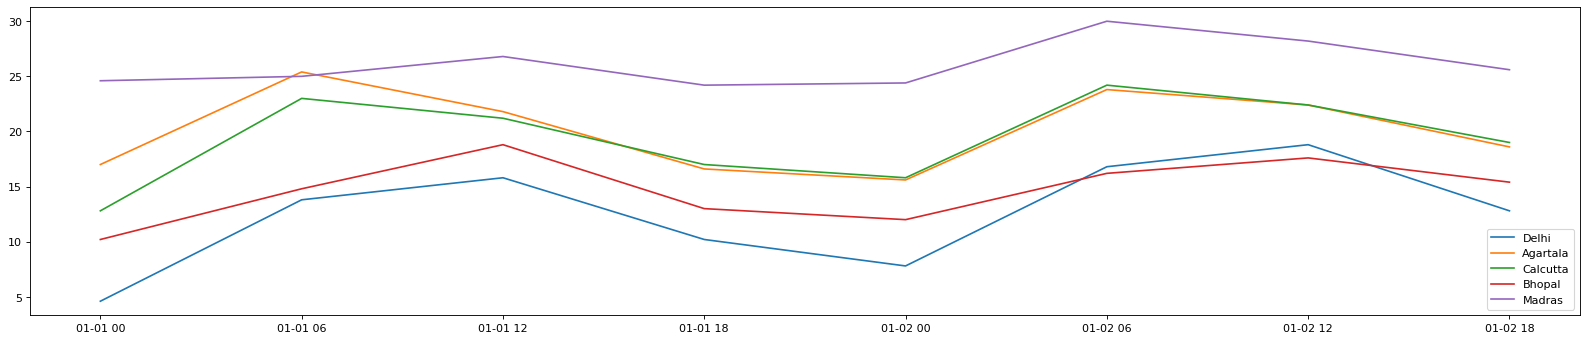

In [ ]:
# Bhopal and Agartala have broken data. Use the other three

fig=plt.figure(figsize=(25, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(delhi_data['temp'][0::6], color='C0', label='Delhi')
plt.plot(agartala_data['temp'][0::6], color='C1', label='Agartala')
plt.plot(calcutta_data['temp'][0::6], color='C2', label='Calcutta')
plt.plot(bhopal_data['temp'][0::6], color='C3', label='Bhopal')
plt.plot(madras_data['temp'][0::6], color='C4', label='Madras')
plt.legend()

In [ ]:
# Loading WeatherBench data
# data guide: https://weatherbench2.readthedocs.io/en/latest/data-guide.html

# Ground truth to compare to
target_path_era5_analysis     = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'
target_path_hres_analysis     = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'

# ============ AI + TRADITIONAL FORECASTS ====================
prediction_path_pangu         = 'gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
prediction_path_graphcast     = 'gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
prediction_path_fuxi          = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'

prediction_path_panguoper     = 'gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
prediction_path_graphcastoper = 'gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'

# traditional model forecasts
prediction_path_ifshres_forecast  = 'gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
prediction_path_ifsens_forecast   = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721_mean.zarr' # can remove "_mean" to get the full ensemble
prediction_path_era5_forecast     = 'gs://weatherbench2/datasets/era5-forecasts/2020-1440x721.zarr'

#prediction_path_neuralgcm    = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'
#prediction_path_sphericalcnn = ''gs://weatherbench2/datasets/sphericalcnn/2020-240x121_equiangular_with_poles.zarr''


In [ ]:
# All datasets available at 6-hourly resolution
time1='2020-01-01T00:00:00.000000000'
time2='2020-01-05T18:00:00.000000000' # 02 to 05 for testing
#time1='2020-05-26T00:00:00.000000000'
#time2='2020-05-27T18:00:00.000000000' # 02 to 05 for testing


ds_era5 = xr.open_zarr(
    target_path_era5_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_hres = xr.open_zarr(
    target_path_hres_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_pangu = xr.open_zarr(
    prediction_path_pangu,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcast = xr.open_zarr(
    prediction_path_graphcast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_fuxi = xr.open_zarr(
    prediction_path_fuxi,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_panguoper = xr.open_zarr(
    prediction_path_panguoper,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcastoper = xr.open_zarr(
    prediction_path_graphcastoper,
    chunks=None,
    storage_options=dict(token='anon'),
)


# traditional
ds_ifshres_fcst = xr.open_zarr(
    prediction_path_ifshres_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_ifsens_fcst = xr.open_zarr(
    prediction_path_ifsens_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_era5_fcst = xr.open_zarr(
    prediction_path_era5_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)

# forecast is made every 6 hours using initial conditions every 12 hours. so time axis has 2 samples per day, but the prediction_delta has 6 samples per timestamp
data_era5          = ds_era5.sel(time=slice(time1, time2))
data_hres          = ds_hres.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_pangu         = ds_pangu.sel(time=slice(time1, time2))
data_graphcast     = ds_graphcast.sel(time=slice(time1, time2))
data_fuxi          = ds_fuxi.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_panguoper     = ds_panguoper.sel(time=slice(time1, time2))
data_graphcastoper = ds_graphcastoper.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_ifshres_fcst  = ds_ifshres_fcst.sel(time=slice(time1, time2))
data_ifsens_fcst   = ds_ifsens_fcst.sel(time=slice(time1, time2))
data_era5_fcst     = ds_era5_fcst.sel(time=slice(time1, time2))

print('Done')

Done


In [ ]:
#data_hres
#data_pangu
#data_graphcast
#data_fuxi

p1=0
p2=20 # 8

lat1 = data_era5['latitude'].values
lat2 = data_hres['latitude'].values
lon = data_era5['longitude'].values

#p_era5 = data_era5['level'].values
t_era5 = data_era5['2m_temperature']
u_era5 = data_era5['10m_u_component_of_wind']
v_era5 = data_era5['10m_v_component_of_wind']

#p_hres = data_hres['level'].values
t_hres = data_hres['2m_temperature'].values
u_hres = data_hres['10m_u_component_of_wind'].values
v_hres = data_hres['10m_v_component_of_wind'].values

#p_pangu = data_pangu['level'].values
t_pangu = data_pangu['2m_temperature'][0,p1:p2,:,:].values
u_pangu = data_pangu['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_pangu = data_pangu['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_graphcast = data_graphcast['level'].values
t_graphcast = data_graphcast['2m_temperature'][0,p1:p2,:,:].values
u_graphcast = data_graphcast['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcast = data_graphcast['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_fuxi = data_fuxi['level'].values
t_fuxi = data_fuxi['2m_temperature'][0,p1:p2,:,:].values
u_fuxi = data_fuxi['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_fuxi = data_fuxi['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_panguoper = data_panguoper['level'].values
t_panguoper = data_panguoper['2m_temperature'][0,p1:p2,:,:].values
u_panguoper = data_panguoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_panguoper = data_panguoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_ifshres_fcst  = data_ifshres_fcst['2m_temperature'][0,p1:p2,:,:].values
u_ifshres_fcst  = data_ifshres_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_ifshres_fcst  = data_ifshres_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_ifsens_fcst   = data_ifsens_fcst['2m_temperature'][0,p1:p2,:,:].values
u_ifsens_fcst   = data_ifsens_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_ifsens_fcst   = data_ifsens_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_era5_fcst     = data_era5_fcst['2m_temperature'][0,p1+1:p2+1,:,:].values
u_era5_fcst     = data_era5_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_era5_fcst     = data_era5_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

# example
#t_fuxi.shape

In [ ]:
#data_era5_fcst['2m_temperature'][0,p1+1:p2+1,:,:]
data_ifsens_fcst['2m_temperature'][0,p1+1:p2+1,:,:]
data_ifshres_fcst['2m_temperature'][0,p1+1:p2+1,:,:]

<xarray.DataArray '2m_temperature' (time: 1, prediction_timedelta: 40,
                                    lat: 721, lon: 1440)> Size: 166MB
[41529600 values with dtype=float32]
Coordinates:
  * lat                   (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.75 90.0
  * lon                   (lon) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 320B 06:00:0...
  * time                  (time) datetime64[ns] 8B 2020-01-05T12:00:00

# Data loading complete. Now compare. First compare radar with ERA5 and HRES analysis. Then, compare forecasts over short lead times.


In [ ]:
# interpolating model timeseries to radar locations - linear interpolation from immediate boundaries will suffice for now
from scipy.interpolate import LinearNDInterpolator

#delhi       = Point(28.6439835,76.9280785)
#bhuj        = Point(23.2420,69.6669) # not complete
#madras      = Point(13.0, 80.1833)
#agartala    = Point(23.8315, 91.2868)
#calcutta    = Point(22.5333, 88.3333)
#bhopal      = Point(23.2833, 77.35)

# delhi
lat0=28.6439835
lon0=76.9280785

#madras
#lat0=13.
#lon0=80.1833

# calcutta
#lat0=22.5333
#lon0=88.3333

ix1=len(lon[lon<lon0])-1
ix2=len(lon[lon<lon0])

# ERA5, Pangu, and PanguOpen will use this
iy1_desc=len(lat1[lat1>lat0])-1
iy2_desc=len(lat1[lat1>lat0])

# Rest will use this
iy1_asc=len(lat2[lat2<lat0])-1
iy2_asc=len(lat2[lat2<lat0])


#x=np.array([lat[ix1], lat[ix1], lat[ix2], lat[ix2]])
#y=np.array([lat[iy1], lat[iy2], lat[iy1], lat[iy2]])
#z=np.array([t_era5[iy1], lat[iy2], lat[iy1], lat[iy2]])
#interp = LinearNDInterpolator(list(zip(x, y)), z)
#Z = interp(lon0, lat0)

delhi_era5 = 0.25*(t_era5[:,iy1_desc,ix1] + t_era5[:,iy1_desc,ix2] + t_era5[:,iy2_desc,ix1] + t_era5[:,iy2_desc,ix2])
delhi_hres = 0.25*(t_hres[:,iy1_asc,ix1] + t_hres[:,iy1_asc,ix2] + t_hres[:,iy2_asc,ix1] + t_hres[:,iy2_asc,ix2])
delhi_hres_fcst = 0.25*(t_ifshres_fcst[:,iy1_asc,ix1] + t_ifshres_fcst[:,iy1_asc,ix2] + t_ifshres_fcst[:,iy2_asc,ix1] + t_ifshres_fcst[:,iy2_asc,ix2])
delhi_hresens_fcst = 0.25*(t_ifsens_fcst[:,iy1_asc,ix1] + t_ifsens_fcst[:,iy1_asc,ix2] + t_ifsens_fcst[:,iy2_asc,ix1] + t_ifsens_fcst[:,iy2_asc,ix2])
delhi_pangu = 0.25*(t_pangu[:,iy1_desc,ix1] + t_pangu[:,iy1_desc,ix2] + t_pangu[:,iy2_desc,ix1] + t_pangu[:,iy2_desc,ix2])
delhi_panguoper = 0.25*(t_panguoper[:,iy1_desc,ix1] + t_panguoper[:,iy1_desc,ix2] + t_panguoper[:,iy2_desc,ix1] + t_panguoper[:,iy2_desc,ix2])
delhi_fuxi = 0.25*(t_fuxi[:,iy1_asc,ix1] + t_fuxi[:,iy1_asc,ix2] + t_fuxi[:,iy2_asc,ix1] + t_fuxi[:,iy2_asc,ix2])
delhi_graphcast = 0.25*(t_graphcast[:,iy1_asc,ix1] + t_graphcast[:,iy1_asc,ix2] + t_graphcast[:,iy2_asc,ix1] + t_graphcast[:,iy2_asc,ix2])
delhi_graphcastoper = 0.25*(t_graphcastoper[:,iy1_asc,ix1] + t_graphcastoper[:,iy1_asc,ix2] + t_graphcastoper[:,iy2_asc,ix1] + t_graphcastoper[:,iy2_asc,ix2])
delhi_era5_fcst = 0.25*(t_era5_fcst[:,iy1_asc,ix1] + t_era5_fcst[:,iy1_asc,ix2] + t_era5_fcst[:,iy2_asc,ix1] + t_era5_fcst[:,iy2_asc,ix2])


# Single-day 48 hours and 120 hours lead time testing

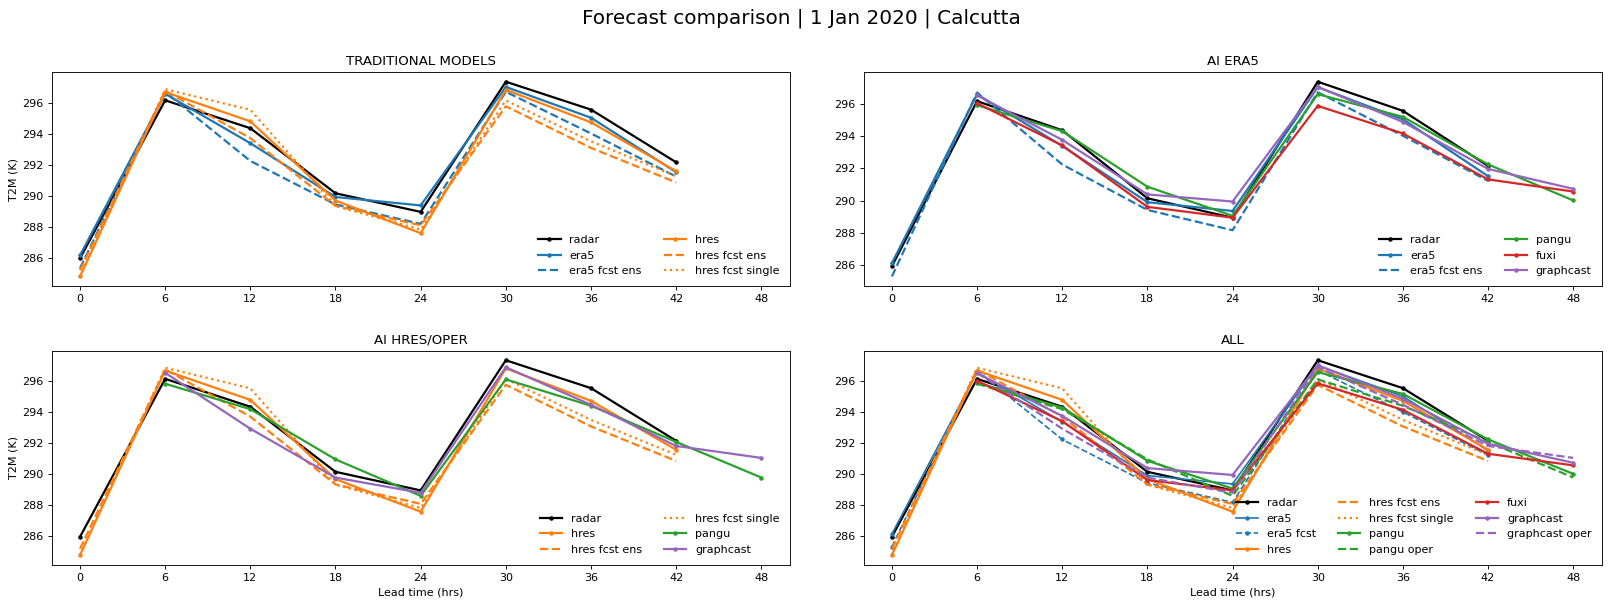

In [ ]:
# comparing forecasts for one day for ERA5 and ERA5 initialized AI models - validation using RADARs

lw=2
t = np.arange(0,48+6,6)
t.shape

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')

fig.suptitle('Forecast comparison | 1 Jan 2020 | Calcutta', size=18)
#fig.suptitle('Forecast comparison | 27 May 2020 | Delhi', size=18)

plt.subplot(221)

#plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '--', linewidth=lw, color='C0', label='era5 fcst ens')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')

plt.legend(frameon=False, ncol=2)
plt.title('TRADITIONAL MODELS')
plt.ylabel('T2M (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,54,6))


plt.subplot(222)

#plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '--', color='C0', linewidth=lw, label='era5 fcst ens')

plt.plot(t[1:], delhi_pangu, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_fuxi, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], delhi_graphcast, '.-', color='C4', linewidth=lw, label='graphcast')


plt.legend(frameon=False, ncol=2)
plt.title('AI ERA5')
plt.xlim(-2,50)
plt.xticks(np.arange(0,54,6))


plt.subplot(223)

#plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')


plt.plot(t[1:], delhi_panguoper, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_graphcastoper, '.-', color='C4', linewidth=lw, label='graphcast')


plt.legend(frameon=False, ncol=2)
plt.title('AI HRES/OPER')
plt.xlabel('Lead time (hrs)')
plt.ylabel('T2M (K)')
plt.xlim(-2,50)
plt.xticks(np.arange(0,54,6))


plt.subplot(224)

#plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '.--', color='C0', label='era5 fcst')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')


plt.plot(t[1:], delhi_pangu, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_panguoper, '--', color='C2', linewidth=lw, label='pangu oper')
plt.plot(t[1:], delhi_fuxi, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], delhi_graphcast, '.-', color='C4', linewidth=lw, label='graphcast')
plt.plot(t[1:], delhi_graphcastoper, '--', color='C4', linewidth=lw, label='graphcast oper')

plt.xlabel('Lead time (hrs)')


plt.legend(frameon=False, ncol=3)
plt.title('ALL')
plt.xlim(-2,50)
plt.xticks(np.arange(0,54,6))

plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.savefig('drive/MyDrive/makdi/t2m_comparison_singleday_calcutta.png', bbox_inches='tight')
#plt.savefig('drive/MyDrive/makdi/t2m_comparison_singleday_delhi_may.png', bbox_inches='tight')

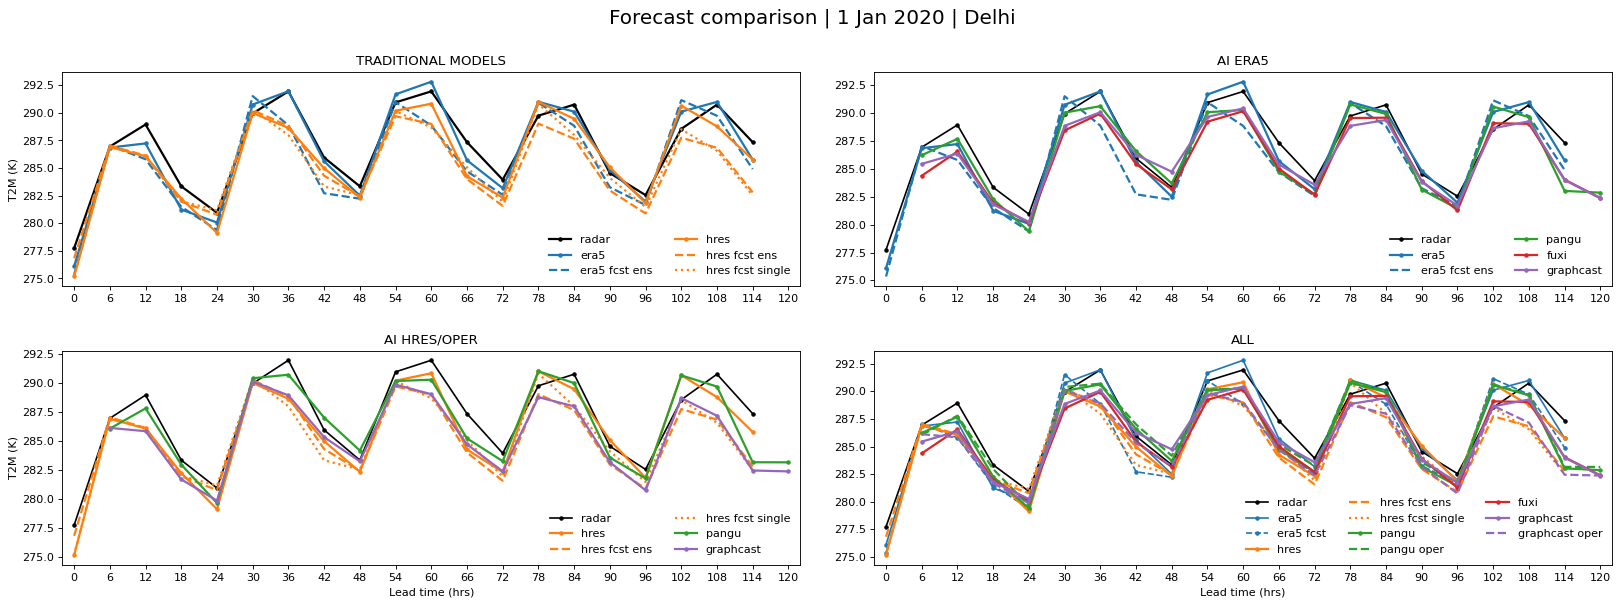

In [ ]:
# testing longer-term forecasts
# comparing forecasts for one day for ERA5 and ERA5 initialized AI models - validation using RADARs

lw=2
t = np.arange(0,120+6,6)
t.shape

fig=plt.figure(figsize=(25, 8), dpi= 80, facecolor='w', edgecolor='k')

fig.suptitle('Forecast comparison | 1 Jan 2020 | Delhi', size=18)
#fig.suptitle('Forecast comparison | 27 May 2020 | Delhi', size=18)

plt.subplot(221)

plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '--', linewidth=lw, color='C0', label='era5 fcst ens')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')

plt.legend(frameon=False, ncol=2)
plt.title('TRADITIONAL MODELS')
plt.ylabel('T2M (K)')
plt.xlim(-2,122)
plt.xticks(np.arange(0,126,6))


plt.subplot(222)

plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', linewidth=lw, color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '--', color='C0', linewidth=lw, label='era5 fcst ens')

plt.plot(t[1:], delhi_pangu, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_fuxi, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], delhi_graphcast, '.-', color='C4', linewidth=lw, label='graphcast')


plt.legend(frameon=False, ncol=2)
plt.title('AI ERA5')
plt.xlim(-2,122)
plt.xticks(np.arange(0,126,6))


plt.subplot(223)

plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')


plt.plot(t[1:], delhi_panguoper, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_graphcastoper, '.-', color='C4', linewidth=lw, label='graphcast')


plt.legend(frameon=False, ncol=2)
plt.title('AI HRES/OPER')
plt.xlabel('Lead time (hrs)')
plt.ylabel('T2M (K)')
plt.xlim(-2,122)
plt.xticks(np.arange(0,126,6))


plt.subplot(224)

plt.plot(t[0:-1],delhi_data['temp'][::6].values + 273.15, '.-', color='k', label='radar')
#plt.plot(t[0:-1],madras_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')
#plt.plot(t[0:-1],calcutta_data['temp'][::6].values + 273.15, '.-', color='k', linewidth=lw, label='radar')

plt.plot(t[0:-1], delhi_era5, '.-', color='C0', label='era5')
plt.plot(t[:-1], delhi_era5_fcst, '.--', color='C0', label='era5 fcst')

plt.plot(t[:-1], delhi_hres, '.-', color='C1', linewidth=lw, label='hres')
plt.plot(t[:-1], delhi_hresens_fcst, '--', color='C1', linewidth=lw, label='hres fcst ens')
plt.plot(t[:-1], delhi_hres_fcst, ':', color='C1', linewidth=lw, label='hres fcst single')


plt.plot(t[1:], delhi_pangu, '.-', color='C2', linewidth=lw, label='pangu')
plt.plot(t[1:], delhi_panguoper, '--', color='C2', linewidth=lw, label='pangu oper')
plt.plot(t[1:], delhi_fuxi, '.-', color='C3', linewidth=lw, label='fuxi')
plt.plot(t[1:], delhi_graphcast, '.-', color='C4', linewidth=lw, label='graphcast')
plt.plot(t[1:], delhi_graphcastoper, '--', color='C4', linewidth=lw, label='graphcast oper')

plt.xlabel('Lead time (hrs)')


plt.legend(frameon=False, ncol=3)
plt.title('ALL')
plt.xlim(-2,122)
plt.xticks(np.arange(0,126,6))

plt.subplots_adjust(hspace=0.3, wspace=0.1)

plt.savefig('drive/MyDrive/makdi/t2m_comparison_singleday_delhi_5days.png', bbox_inches='tight')
#plt.savefig('drive/MyDrive/makdi/t2m_comparison_singleday_delhi_may.png', bbox_inches='tight')